In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import pandas as pd

from IPython.core.debugger import set_trace

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
device

device(type='cuda')

In [3]:
#expr = pd.read_csv("data/Muscle_Skeletal.v8.normalized_expression.bed.gz", sep = "\t")
from google.colab import drive
drive.mount('/content/drive')
DATADIR = "/content/drive/My Drive/Genomics_ML/Term_Project/"

df = pd.read_csv(DATADIR + "Muscle_Skeletal.v8.normalized_expression.bed.gz", sep = "\t")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Merge and drop 
gene_ids = df[df.columns[:4]]
expr = df.drop(df.columns[:4], axis = 1)

In [0]:
expr_tensor = torch.tensor(expr.values)

In [6]:
expr.columns

Index(['GTEX-1117F', 'GTEX-111CU', 'GTEX-111FC', 'GTEX-111VG', 'GTEX-111YS',
       'GTEX-1122O', 'GTEX-1128S', 'GTEX-113JC', 'GTEX-117XS', 'GTEX-117YW',
       ...
       'GTEX-ZY6K', 'GTEX-ZYFC', 'GTEX-ZYFD', 'GTEX-ZYFG', 'GTEX-ZYT6',
       'GTEX-ZYW4', 'GTEX-ZYY3', 'GTEX-ZZ64', 'GTEX-ZZPT', 'GTEX-ZZPU'],
      dtype='object', length=706)

Let's start by doing some quick EDA, with running PCA on the feature matrix

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

PCs = pca.fit_transform(expr.transpose())

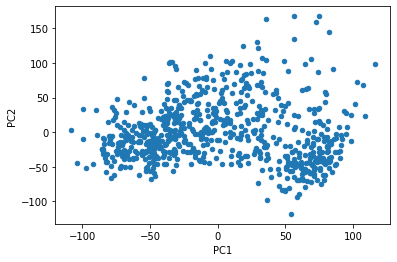

In [8]:
pc_df = pd.DataFrame(data = PCs, columns = ['PC1', 'PC2'])
pc_df.plot.scatter(x = "PC1", y = "PC2")

### Build the Network
Now build a gene expression data loader for feeding normalized gene expression counts into the VAE. 

In [0]:
class GeneExpressionDataset(Dataset):
    '''Expression dataset in the format used in GTEx'''
    
    def __init__(self, expression_matrix, sample_names):
        '''
        Args:
            expression_matrix (torch tensor) : Since the data isn't too big, it's easier to load the whole thing
        '''
        self.expr = expression_matrix
        self.sample_names = sample_names
    
    def __len__(self):
        return self.expr.shape[1]
    
    def __getitem__(self, idx):
        gene_counts = self.expr[:,idx]
        indv = self.sample_names[idx]
        sample = {'gene_counts' : gene_counts, 'indv' : indv}
        
        return sample

In [0]:
skeletal_muscle_expression = GeneExpressionDataset(expr_tensor, expr.columns)

In [0]:
in_dim = expr.shape[0]

### Set model parameters

In [0]:
BATCH_SIZE = 50    # The number of data points in each batch
N_EPOCHS = 10      # number of times to run the model on complete data
INPUT_DIM = in_dim # The size of each input
HIDDEN_DIM = 512   # hidden dimension
LATENT_DIM = 60    # latent vector dimension
lr = 1e-4      # The learning rate hyperparameter

In [0]:
n_train = int(skeletal_muscle_expression.__len__() * .8)
n_test = int(skeletal_muscle_expression.__len__() * .2) + 1

train_dataset, test_dataset = torch.utils.data.random_split(skeletal_muscle_expression, [n_train, n_test])

### Define two different data iterators

In [0]:
train_iterator = DataLoader(test_dataset, batch_size = BATCH_SIZE)
test_iterator = DataLoader(test_dataset, batch_size = BATCH_SIZE)

full_data_train_iterator = DataLoader(skeletal_muscle_expression, batch_size = BATCH_SIZE)

Now let's actually build the autoencoder class. We define an Encoder and a Decoder

In [0]:
class Encoder(nn.Module):
    ''' The encoder part of the VAE
    
    '''
    
    def __init__(self, input_dim, hidden_dim, z_dim, dropout_p = .2):
        '''
        Args:
            input_dim: An integer indicating the size of the input (Dim1 * Dim2 for a square input matrix)
            hidden_dim: An integer indicating the size of the hidden dimension
            z_dim: An integer indicating the latent dimension. This is the bottleneck
        '''
        super().__init__()
        
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)
        self.dropout = nn.Dropout(dropout_p)
        
    def forward(self, x):
        # x is the shape of [batch_size, input_dim]
        
        # hidden is of shape [batch_size, hidden_dim]
        hidden = F.relu(self.linear(x))

        # apply a bit of dropout to the hidden layer
        hidden = self.dropout(hidden)
        
        # z_mu is of shape [batch_size, z_dim]
        z_mu = self.mu(hidden)
        
        # z_var is of shape [batch_size, z_dim]
        z_var = self.var(hidden)
        
        return z_mu, z_var

In [0]:
class Decoder(nn.Module):
    ''' The decoder part of the VAE
    
    '''
    def __init__(self, z_dim, hidden_dim, output_dim):
        '''
        Args:
            z_dim: An integer indicating the size of the bottleneck layer
            hidden_dim: An integer indicating the size of the hidden dimension
            output_dim: An integer indicating the output dimension, which is the same as the input dimension
        '''
        super().__init__()
        
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x is of shape [batch_size, z_dim]
        
        # hidden is of shape [batch_size, z_dim]
        hidden = F.relu(self.linear(x))
        #hidden = self.linear(x)
        
        # predicted is of shape [batch_size, output_dim]
        #predicted = torch.sigmoid(self.out(hidden))
        predicted = self.out(hidden)

        return predicted

Now combine the encoder and decoder into a full VAE module

In [0]:
class VAE(nn.Module):
    ''' This is the VAE, which takes an encoder and a decoder
    
    '''
    def __init__(self, enc, dec):
        super().__init__()
        
        self.enc = enc
        self.dec = dec
        
    def forward(self, x):
        # encode
        z_mu, z_var = self.enc(x)
        
        # Sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        #x_sample = F.relu(eps.mul(std).add_(z_mu))
        x_sample = eps.mul(std).add_(z_mu)

        # decode
        predicted = self.dec(x_sample)
        return predicted, z_mu, z_var, x_sample

**Training** Now let's create an instance of the VAE and train it up

In [0]:
# encoder
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM, .05)

# decoder 
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)

# Define two different models:
  One with training and testing split, and one where we just train ont he entire dataset, and don't checkt the testing data. 

In [0]:
# Train test model
# vae
train_test_model = VAE(encoder, decoder).to(device)

# optimizer 
train_test_optimizer = optim.Adam(train_test_model.parameters(), lr = lr)

# Full dataset model
full_data_model = VAE(encoder, decoder).to(device)
full_data_optmizer = optim.Adam(full_data_model.parameters(), lr = lr)

In [0]:
params = [i for i in full_data_model.parameters()]

In [21]:
[i.shape for i in params]

[torch.Size([512, 21031]),
 torch.Size([512]),
 torch.Size([60, 512]),
 torch.Size([60]),
 torch.Size([60, 512]),
 torch.Size([60]),
 torch.Size([512, 60]),
 torch.Size([512]),
 torch.Size([21031, 512]),
 torch.Size([21031])]

In [22]:
train_test_model

VAE(
  (enc): Encoder(
    (linear): Linear(in_features=21031, out_features=512, bias=True)
    (mu): Linear(in_features=512, out_features=60, bias=True)
    (var): Linear(in_features=512, out_features=60, bias=True)
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec): Decoder(
    (linear): Linear(in_features=60, out_features=512, bias=True)
    (out): Linear(in_features=512, out_features=21031, bias=True)
  )
)

In [0]:
def train(it, model, optimizer):
    '''
    Args:
      it: An iterator to use for training the vae
      model: A model to train
      optimizer: An optimizer which is linked to the model
    '''
    # set the train mode
    model.train()
    
    # loss of the epoch
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    for i, x in enumerate(it):
        x = x['gene_counts']
        x = x.to(device).float()

        #print(x.shape)
        if x.shape[0] != BATCH_SIZE:
          continue

        # update the gradients to zero
        optimizer.zero_grad()
        
        # Forward pass
        x_sample, z_mu, z_var, z_sample = model(x)
        
        # reconstruction loss
        # recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)
        recon_loss = F.l1_loss(x_sample, x)
        # recon_loss = F.mse_loss(x_sample, x)


        # KL divergence loss
        kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
        
        #set_trace()

        # import math
        # if math.isnan(kl_loss):
        #   set_trace()
        
        # total loss
        loss = recon_loss #+ kl_loss
        #loss = kl_loss

        # backward pass
        loss.backward()
        train_loss += loss.item()
        
        # record the kl and recon loss as well
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()

        # update the weights
        optimizer.step()

        
    
    return train_loss, train_recon_loss, train_kl_loss

In [0]:
# def test(it, model):
#     # set the evaluation mode
#     model.eval()
#     '''
#     Args:
#       it: An iterator to use for testing the model as it trains
#       model: A model used to test the parameters
#     '''
    
#     test_loss = 0
#     test_kl_loss = 0
#     test_recon_loss = 0
    
#     # don't need track gradients, since we don't update parameters in this step
#     with torch.no_grad():
#         for i, x in enumerate(it):
#             # reshape the data
#             x = x['gene_counts']
#             x = x.to(device).float()
            
#             # forward pass
#             x_sample, z_mu, z_var, z_sample = model(x)
            
#             # reconstruction loss
#             # recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)
#             recon_loss = F.l1_loss(x_sample, x)
            
#             # kl divergence loss
#             kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
            
#             # total loss
#             loss = recon_loss #+ kl_loss
#             test_loss += loss.item()

#             # record kl and recon loss terms as well
#             test_kl_loss =+ kl_loss.item()
#             test_recon_loss =+ recon_loss.item()
  
        
#     return test_loss, test_recon_loss, test_kl_loss

# Train the model for several epochs

In [0]:
# best_test_loss = float('inf')

# for e in range(N_EPOCHS):
    
#     train_loss, train_recon_loss, train_kl_loss = train(train_iterator, train_test_model, train_test_optimizer)
#     test_loss, test_recon_loss, test_kl_loss = test(test_iterator, train_test_model)
    
#     train_loss /= len(train_dataset)
#     test_loss /= len(test_dataset)
    
#     print(f"Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}")
#     print(f"Epoch {e}, Train Recon: {train_recon_loss:.2f}, Test Recon: {test_recon_loss:.2f}")
#     print(f"Epoch {e}, Train KL: {train_kl_loss:.2f}, Test KL: {test_kl_loss:.2f}")

#     if best_test_loss > test_loss:
#         best_test_loss = test_loss
#         patience_counter = 1
#     else: 
#         patience_counter += 1
    
#     if patience_counter > 3:
#         break

Train again, but use the full dataset and don't test it. Testing doesn't seem as important in this case. 

In [27]:
best_train_loss = float('inf')
train_loss_list = []
check_point_filename = "expression_vae_model.pt"
patience = 20 # for early stopping
patience_counter = patience

for e in range(1000):  
  train_loss, train_recon_loss, train_kl_loss = train(full_data_train_iterator, full_data_model, full_data_optmizer)
  
  print(f"Epoch {e}, Train Loss: {train_loss:.2f}, Train Recon: {train_recon_loss:.2f}, Train KL: {train_kl_loss:.2f}")
  
  train_loss_list.append(train_loss)

  if train_loss < best_train_loss: 
    torch.save(full_data_model.state_dict(), check_point_filename)
    best_train_loss = train_loss
    patience_counter = patience
  else: 
      patience_counter -= 1
      if patience_counter <= 0: 
          full_data_model.load_state_dict(torch.load(check_point_filename)) # recover the best model so far
          break

Epoch 0, Train Loss: 11.33, Train Recon: 11.33, Train KL: 8287.84
Epoch 1, Train Loss: 11.09, Train Recon: 11.09, Train KL: 33732.58
Epoch 2, Train Loss: 10.68, Train Recon: 10.68, Train KL: 79422.14
Epoch 3, Train Loss: 10.16, Train Recon: 10.16, Train KL: 121383.26
Epoch 4, Train Loss: 9.79, Train Recon: 9.79, Train KL: 138336.47
Epoch 5, Train Loss: 9.58, Train Recon: 9.58, Train KL: 144925.05
Epoch 6, Train Loss: 9.44, Train Recon: 9.44, Train KL: 152627.97
Epoch 7, Train Loss: 9.31, Train Recon: 9.31, Train KL: 162273.91
Epoch 8, Train Loss: 9.14, Train Recon: 9.14, Train KL: 171888.45
Epoch 9, Train Loss: 8.99, Train Recon: 8.99, Train KL: 181865.14
Epoch 10, Train Loss: 8.86, Train Recon: 8.86, Train KL: 193184.01
Epoch 11, Train Loss: 8.75, Train Recon: 8.75, Train KL: 203841.64
Epoch 12, Train Loss: 8.69, Train Recon: 8.69, Train KL: 213031.05
Epoch 13, Train Loss: 8.64, Train Recon: 8.64, Train KL: 224804.90
Epoch 14, Train Loss: 8.52, Train Recon: 8.52, Train KL: 237478.31
E

In [29]:
check_point_filename = "expression_vae_model.pt"
full_data_model.load_state_dict(torch.load(check_point_filename)) # recover the best model so far

<All keys matched successfully>

In [0]:
x_test = next(iter(train_dataset))
x_test = x_test['gene_counts']
x_test = x_test.to(device).float()

Text(0, 0.5, 'L1 Loss')

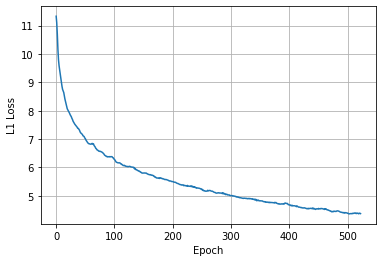

In [44]:
import matplotlib.pyplot as plt
#lossplot = plt.figure()
plt.plot(train_loss_list)
plt.grid(which="both")
plt.xlabel("Epoch")
plt.ylabel("L1 Loss")

Now let's see if we can interpret the parameters of the VAE

In [0]:
x = next(iter(train_iterator))
x_pred = full_data_model(x['gene_counts'].to(device).float())

Text(0, 0.5, 'Count')

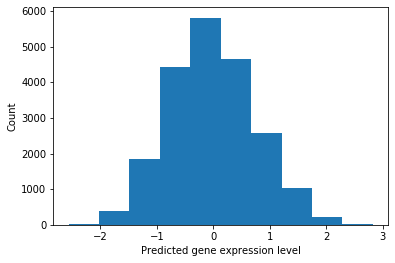

In [90]:
plt.hist(x_pred[0][0,:].to('cpu').detach().numpy(), )
plt.xlabel("Predicted gene expression level")
plt.ylabel("Count")


In [0]:
predicted_full, z_mu_full, z_var_full, x_sample_full = full_data_model(expr_tensor.transpose(0,1).to(device).float())

In [47]:
x_sample_full.min()

tensor(-32.6131, device='cuda:0', grad_fn=<MinBackward1>)

In [0]:
predicted = predicted_full.cpu().detach().numpy()
mu_hat = z_mu_full.cpu().detach().numpy()
sigma_hat = z_var_full.cpu().detach().numpy()
z_sample_full = x_sample_full.cpu().detach().numpy()

Plot some of the parameters together

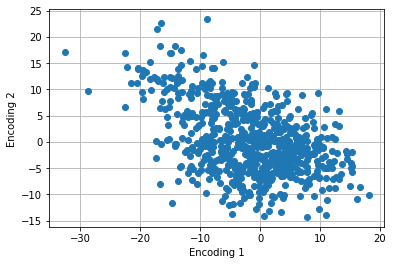

In [51]:
plt.plot(mu_hat[:,0], mu_hat[:,1], "o")
plt.xlabel("Encoding 1")
plt.ylabel("Encoding 2")
plt.grid("both")

# Save the encodings to disk for downstream analysis

In [0]:
mu_hat_df = pd.DataFrame(mu_hat)
mu_hat_df.index = expr.columns

mu_hat_df.to_csv("/content/drive/My Drive/Genomics_ML/Term_Project/VAE_features_mod8.tsv", sep = "\t")

In [0]:
z_sample_df = pd.DataFrame(z_sample_full)
z_sample_df.index = expr.columns

z_sample_df.to_csv("/content/drive/My Drive/Genomics_ML/Term_Project/VAE_sampled_encodings_mod8.tsv", sep = "\t")

In [0]:
z_sample_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
GTEX-1117F,0.265864,7.115016,6.463391,-1.275506,1.096754,0.277798,-1.691756,17.070742,-8.388762,-3.458261,13.496694,-2.450239,-0.346279,3.214376,13.048671,-5.024584,2.138215,-1.031826,11.169999,3.060988,16.176662,1.098244,1.970720,4.021657,-5.307627,-1.935272,5.517797,9.079120,-5.595567,-2.223314,5.353780,0.861494,-1.834256,-2.833165,2.623549,1.718788,-4.726351,-6.863762,-5.928131,2.284013,-2.695924,6.411428,6.560845,7.764163,-10.264614,8.329651,-6.351592,0.639971,-9.972749,-10.434846,-16.389774,-0.356915,-3.701865,0.683792,-5.758471,4.279435,-0.317446,3.584267,-9.160974,-11.550786
GTEX-111CU,2.616943,0.368409,17.277130,-0.310370,-4.633943,-3.289435,-1.969579,-9.216500,10.295173,-10.127389,0.105558,-1.636911,5.654346,3.661951,9.201623,0.807339,-2.544847,-5.488959,4.845780,3.413965,-2.973727,7.682764,-7.437035,10.078281,-6.676647,1.178434,-8.766127,-9.360144,1.348492,-1.040947,-1.432274,2.997222,2.340733,1.154048,-4.264346,-0.724586,-3.958160,0.099237,-0.767736,3.471448,3.312159,-2.697488,-3.201226,4.097495,0.723758,-0.515834,-2.023375,4.125047,-4.293909,5.599420,3.024261,-0.791915,-0.800692,-10.834782,4.223975,-6.817644,1.724171,4.669887,-3.133477,7.186244
GTEX-111FC,1.175935,-2.167860,-4.141553,-1.468553,3.687068,5.006702,4.354688,2.198951,-8.312825,-1.711016,-1.587125,-0.342199,-4.275047,-11.986674,-8.528725,-4.725394,2.927830,1.758600,4.040405,-8.367025,8.989390,-8.601574,4.554093,-5.547221,6.961008,-1.595060,-1.606453,1.376414,-2.522677,1.419331,0.565849,-4.076259,-1.917618,1.080475,4.210308,-0.283881,-1.514616,2.372079,2.544368,-9.823385,1.036538,-2.671635,-2.743570,-2.127642,-2.616185,-0.491144,9.371859,-6.025596,5.847030,5.222796,4.380637,-2.723012,-5.115726,-0.224439,3.100211,5.617967,0.381916,-7.964266,6.798524,-9.858397
GTEX-111VG,2.421447,-1.488859,-2.857414,0.176728,7.016105,0.453281,3.923739,6.572407,-2.236229,-3.569691,-3.774837,0.150795,-5.455135,-9.120070,-8.536239,-4.888513,-6.137583,1.549096,-5.596967,-0.917319,4.733740,-6.510977,1.887619,1.560652,-0.653023,-0.260565,1.108885,-2.121945,-2.108968,1.438537,-1.035168,-1.062428,0.662695,-0.936414,9.425068,-0.233596,-7.013874,-1.918070,4.412585,-9.899310,-3.064275,3.267043,1.399549,-8.834957,5.457384,1.299678,6.823809,-5.241175,5.123028,5.483274,-0.874100,4.008304,-0.809940,1.786791,3.240755,1.353088,-6.411755,-1.460683,5.809742,1.887657
GTEX-111YS,-4.875555,-3.729248,9.285007,-0.293256,2.465866,-2.651800,-0.935429,-2.277740,-0.880084,-4.294170,0.318590,-3.983540,3.192389,6.115866,1.737120,1.859223,2.527142,0.957372,-4.844350,6.435821,1.172524,-1.667784,-3.785508,3.312236,-1.217576,0.791682,-6.153082,-8.823208,3.837302,1.587464,2.806995,7.404770,-2.251824,4.831526,-2.675915,-1.495518,2.529317,-5.302433,-2.959451,5.581287,0.587794,-2.024107,3.831814,2.461200,5.308336,-3.530768,-4.756313,8.203328,-2.294644,-0.090427,5.405632,-5.175314,1.985363,0.630793,6.266582,-6.572596,0.241654,1.853803,7.918075,3.698580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-ZYW4,-7.359527,-0.058170,-0.960706,4.819886,0.464806,-2.825369,0.852447,11.348620,-10.189432,0.007568,4.886947,2.549149,-1.212035,0.205032,4.363178,-5.100114,1.234626,1.677331,2.046442,10.104269,12.147337,-3.403403,-1.420767,3.307235,-4.806844,3.476475,4.937311,4.151942,1.972516,2.148857,-0.934704,6.551661,-7.446785,0.377437,-1.345398,4.312770,-5.052663,-3.235194,-1.999726,1.589789,-0.822290,-0.041333,5.355163,4.740809,-5.154423,5.782866,-4.347436,1.761703,-5.453216,-11.055983,-8.925767,2.039093,1.271204,-1.351312,-3.535690,1.943539,-1.186924,3.707163,1.784048,-6.265659
GTEX-ZYY3,7.308047,8.634524,5.700824,-1.175858,1.968715,-2.044350,2.140105,6.351189

In [0]:
predicted[0].size

21031

Text(0, 0.5, 'Predicted gene expression level')

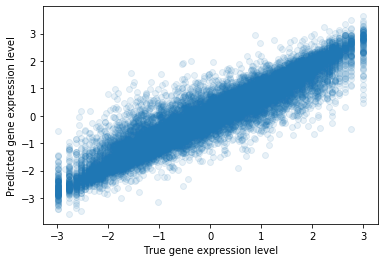

In [85]:
plt.plot(expr["GTEX-1117F"], predicted[0], "o", alpha=.1)
plt.xlabel("True gene expression level")
plt.ylabel("Predicted gene expression level")

In [0]:
predicted[0]

array([ 1.0540558 ,  1.0127403 ,  0.08813736, ..., -1.032147  ,
        0.52029014,  1.8652049 ], dtype=float32)

# Visualize the network 

In [0]:
from graphviz import Digraph

from graphviz import Digraph
from torch.autograd import Variable

# From https://discuss.pytorch.org/t/print-autograd-graph/692/16
def make_dot(var, params):
    """ Produces Graphviz representation of PyTorch autograd graph
    
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    param_map = {id(v): k for k, v in params.items()}
    print(param_map)
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

In [58]:
from torchvision import models
inputs = torch.randn(1,3,224,224)
resnet18 = models.resnet18()
y = resnet18(Variable(inputs))
# print(y)

g = make_dot(y, resnet18.state_dict())
g.view()

{139763910073728: 'conv1.weight', 139763910074160: 'bn1.weight', 139763910074232: 'bn1.bias', 139763909670952: 'bn1.running_mean', 139763909671456: 'bn1.running_var', 139763909671672: 'bn1.num_batches_tracked', 139763909736056: 'layer1.0.conv1.weight', 139763909736416: 'layer1.0.bn1.weight', 139763909735408: 'layer1.0.bn1.bias', 139763909737640: 'layer1.0.bn1.running_mean', 139763909737136: 'layer1.0.bn1.running_var', 139763909737352: 'layer1.0.bn1.num_batches_tracked', 139763909736344: 'layer1.0.conv2.weight', 139763909734616: 'layer1.0.bn2.weight', 139763909734832: 'layer1.0.bn2.bias', 139763909735336: 'layer1.0.bn2.running_mean', 139763909735480: 'layer1.0.bn2.running_var', 139763909735696: 'layer1.0.bn2.num_batches_tracked', 139763909735048: 'layer1.1.conv1.weight', 139763909734976: 'layer1.1.bn1.weight', 139763909714856: 'layer1.1.bn1.bias', 139763909717736: 'layer1.1.bn1.running_mean', 139763909716944: 'layer1.1.bn1.running_var', 139763909715864: 'layer1.1.bn1.num_batches_tracked

'Digraph.gv.pdf'

In [75]:
x_pred[0].grad_fn

In [80]:
#predicted_tensor = full_data_model(expr_tensor.transpose(0,1))[0]

model_plot = make_dot(x_pred[0], dict(full_data_model.named_parameters()))

{139764561146288: 'enc.linear.weight', 139764561146504: 'enc.linear.bias', 139764561148016: 'enc.mu.weight', 139764561147296: 'enc.mu.bias', 139764561147584: 'enc.var.weight', 139764561146432: 'enc.var.bias', 139764561329752: 'dec.linear.weight', 139764561326440: 'dec.linear.bias', 139764561328960: 'dec.out.weight', 139764561328456: 'dec.out.bias'}


In [83]:
model_plot.render(filename = DATADIR + "vae_model_graph", format='png')

'/content/drive/My Drive/Genomics_ML/Term_Project/vae_model_graph.png'

In [84]:
df.shape

(21031, 710)